In [1]:
import yfinance as yf
import pandas as pd
import os

In [2]:
if os.path.exists("sp500.csv"):
    sp500 = pd.read_csv("sp500.csv", index_col=0)
else:
    sp500 = yf.Ticker("^GSPC")
    sp500 = sp500.history (period="max")
    sp500.to_csv("sp500.csv")

In [3]:
sp500.index = pd.to_datetime (sp500.index)

In [4]:
sp500

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
...,...,...,...,...,...,...,...
2023-08-04 00:00:00-04:00,4513.959961,4540.339844,4474.549805,4478.029785,4143310000,0.0,0.0
2023-08-07 00:00:00-04:00,4491.580078,4519.839844,4491.149902,4518.439941,3493920000,0.0,0.0
2023-08-08 00:00:00-04:00,4498.029785,4503.310059,4464.390137,4499.379883,3884910000,0.0,0.0


<Axes: xlabel='Date'>

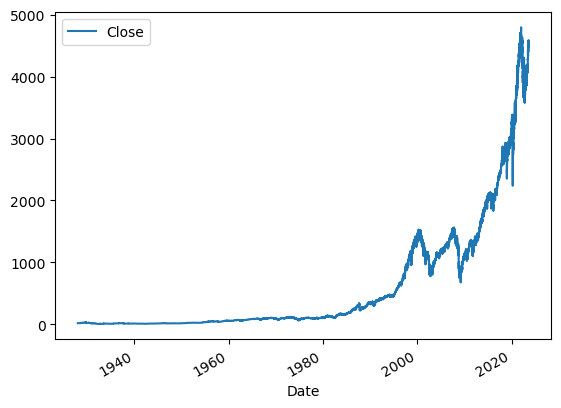

In [5]:
sp500.plot.line (y="Close", use_index=True)

In [6]:
del sp500["Stock Splits"]

In [7]:
sp500["Tomorrow"] =sp500["Close"].shift(-1)

In [8]:
sp500["Target"] = (sp500["Tomorrow"]> sp500["Close"]).astype(int)

In [9]:
sp500 = sp500.loc["1990-01-01":].copy()

In [10]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)
train = sp500.iloc[:-100]
test = sp500.iloc[-100:]
predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train [predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [11]:
from sklearn.metrics import precision_score
preds = model.predict(test[predictors])
preds = pd.Series (preds, index=test.index)
precision_score (test["Target"], preds)

0.5964912280701754

<Axes: xlabel='Date'>

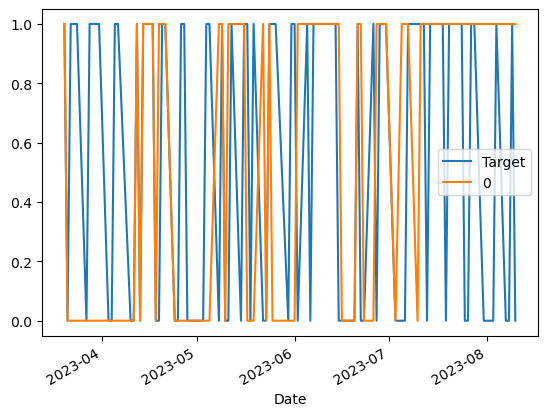

In [12]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

In [13]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test [ "Target"], preds], axis=1)
    return combined

In [14]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i: (i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)

    return pd.concat(all_predictions)

In [17]:
predictions = backtest (sp500, model, predictors)

In [18]:
precision_score (predictions["Target"], predictions["Predictions"])

0.5295974743488555

In [20]:
predictions["Target"].value_counts()/ predictions.shape[0]

1    0.533937
0    0.466063
Name: Target, dtype: float64

In [21]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
  rolling_averages = sp500.rolling(horizon).mean()

  ratio_column= f"Close_Ratio {horizon}"
  sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]

  trend_column = f"Trend_{horizon}"
  sp500[trend_column] = sp500.shift(1).rolling (horizon). sum()["Target"]
  
  new_predictors+= [ratio_column, trend_column]

In [22]:
sp500 = sp500.dropna(subset=sp500.columns[sp500.columns != "Tomorrow"])

In [23]:
sp500

,Open,High,Low,Close,Volume,Dividends,Tomorrow,Target,Close_Ratio 2,Trend_2,Close_Ratio 5,Trend_5,Close_Ratio 60,Trend_60,Close_Ratio 250,Trend_250,Close_Ratio 1000,Trend_1000
Date,,,,,,,,,,,,,,,,,,
1993-12-14 00:00:00-05:00,465.730011,466.119995,462.459991,463.059998,275050000,0.0,461.839996,0,0.997157,1.0,0.996617,1.0,1.000283,32.0,1.028047,127.0,1.176082,512.0
1993-12-15 00:00:00-05:00,463.059998,463.690002,461.839996,461.839996,331770000,0.0,463.339996,1,0.998681,0.0,0.995899,1.0,0.997329,32.0,1.025151,126.0,1.172676,512.0
1993-12-16 00:00:00-05:00,461.859985,463.980011,461.859985,463.339996,284620000,0.0,466.380005,1,1.001621,1.0,0.999495,2.0,1.000311,32.0,1.028274,127.0,1.176163,513.0
1993-12-17 00:00:00-05:00,463.339996,466.380005,463.339996,466.380005,363750000,0.0,465.850006,0,1.003270,2.0,1.004991,3.0,1.006561,32.0,1.034781,128.0,1.183537,514.0
1993-12-20 00:00:00-05:00,466.380005,466.899994,465.529999,465.850006,255900000,0.0,465.299988,0,0.999431,1.0,1.003784,2.0,1.005120,32.0,1.033359,128.0,1.181856,513.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-04 00:00:00-04:00,4513.959961,4540.339844,4474.549805,4478.029785,4143310000,0.0,4518.439941,1,0.997343,0.0,0.988135,1.0,1.026023,34.0,1.102385,120.0,1.169678,535.0
2023-08-07 00:00:00-04:00,4491.580078,4519.839844,4491.149902,4518.439941,3493920000,0.0,4499.379883,0,1.004492,1.0,1.000165,1.0,1.033779,34.0,1.111919,121.0,1.179718,535.0
2023-08-08 00:00:00-04:00,4498.029785,4503.310059,4464.390137,4499.379883,3884910000,0.0,4467.709961,0,0.997886,1.0,0.999368,1.0,1.027972,34.0,1.106818,121.0,1.174248,534.0


In [24]:
predictions = backtest(sp500, model, new_predictors)

In [25]:
predictions["Predictions"].value_counts()

1    3699
0    1268
Name: Predictions, dtype: int64

In [26]:
precision_score (predictions["Target"], predictions["Predictions"])

0.551500405515004

In [27]:
predictions["Target"].value_counts()/ predictions.shape[0]

1    0.543789
0    0.456211
Name: Target, dtype: float64

In [28]:
predictions

,Target,Predictions
Date,,
2003-11-14 00:00:00-05:00,0,1
2003-11-17 00:00:00-05:00,0,1
2003-11-18 00:00:00-05:00,1,1
2003-11-19 00:00:00-05:00,0,1
2003-11-20 00:00:00-05:00,1,1
...,...,...
2023-08-04 00:00:00-04:00,1,1
2023-08-07 00:00:00-04:00,0,0
2023-08-08 00:00:00-04:00,0,1
